In [2]:
# Import necessary libraries

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import kagglehub
from torch.utils.data import Dataset,DataLoader
import os
from torchvision.datasets import ImageFolder
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt
from torchvision.transforms import transforms
from PIL import Image

In [3]:
# Define constants

# Path where the dataset will be downloaded by kagglehub
download_path = kagglehub.dataset_download("navoneel/brain-mri-images-for-brain-tumor-detection")

# Desired image size for processing
img_size = (256, 256)

# Name of the output CSV file to store pixel data
output_csv_file = "brain_mri_pixels.csv"

In [4]:
def img_to_csv(download_path, img_size, output_csv):
    

    data = []

    # Define the valid class names (directories) to process
    valid_class = ['no', 'yes']

    # List all items in the download path to find class directories
    temp_class = os.listdir(download_path)
    class_labels = []

    # Filter for directories that are in our valid_class list
    for item in temp_class:
        if item in valid_class:
            class_labels.append(item)

    print(f"Classes to process: {class_labels}")        

    # Iterate through each valid class directory
    for label_name in class_labels:
        class_path = os.path.join(download_path, label_name)
        
         # Assign a numerical label (0 for 'no', 1 for 'yes')
        label = 1 if label_name.lower() == 'yes' else 0
        print(f"\nProcessing class '{label_name}' with assigned label: {label}")

         # List image files within the current class directory
        img_files = os.listdir(class_path)

        # Process each image file with a progress bar
        for img_name in tqdm(img_files, desc=f"Label: {label_name}"):
            img_path = os.path.join(class_path, img_name)

            try:
                # Read the image in grayscale
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

                # Skip if image could not be read
                if img is None:
                    print(f"Warning: Could not read image {img_path}, skipping.")
                    continue
                
                # Resize the image to the target size
                resized_img = cv2.resize(img, img_size)

                 # Flatten the resized image pixels
                flattened_img = resized_img.flatten()

                # Insert the label at the beginning of the pixel data row
                row = np.insert(flattened_img, 0, label)

                 # Append the row to the data list
                data.append(row)

            except Exception as e:

                 # Print error message for any exceptions during processing
                print(f"Error processing image {img_path}: {e}")    

     # Check if any data was collected
    if not data:
        print("Error: No data was collected. Cannot create DataFrame.")
        return None # Return None or an empty DataFrame

     # Define column names: 'label' followed by pixel indices
    num_pixels = img_size[0] * img_size[1]
    columns = ['label'] + [f"pixel_{i+1}" for i in range(num_pixels)] 

     # Create a pandas DataFrame from the collected data
    df = pd.DataFrame(data, columns=columns)

   # Shuffle the DataFrame rows randomly
    df = df.sample(frac=1).reset_index(drop=True)

    try:
        print(f"Saving DataFrame to {output_csv}")
         # Save the DataFrame to a CSV file without the index
        df.to_csv(output_csv, index=False)

    except Exception as e:
        print(f"Error saving file to {output_csv}: {e}")

    # Return the processed DataFrame
    return df

In [5]:
df = img_to_csv(download_path, img_size, output_csv_file)

Classes to process: ['no', 'yes']

Processing class 'no' with assigned label: 0


Label: no: 100%|██████████| 98/98 [00:00<00:00, 1070.13it/s]



Processing class 'yes' with assigned label: 1


Label: yes: 100%|██████████| 155/155 [00:00<00:00, 1279.21it/s]


Saving DataFrame to brain_mri_pixels.csv


In [6]:
df.shape

(253, 65537)

In [7]:
# Set the device to GPU if available, otherwise use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"using device: {device}")

using device: cuda


In [8]:
# Set a manual seed for reproducibility in PyTorch
torch.manual_seed(42)

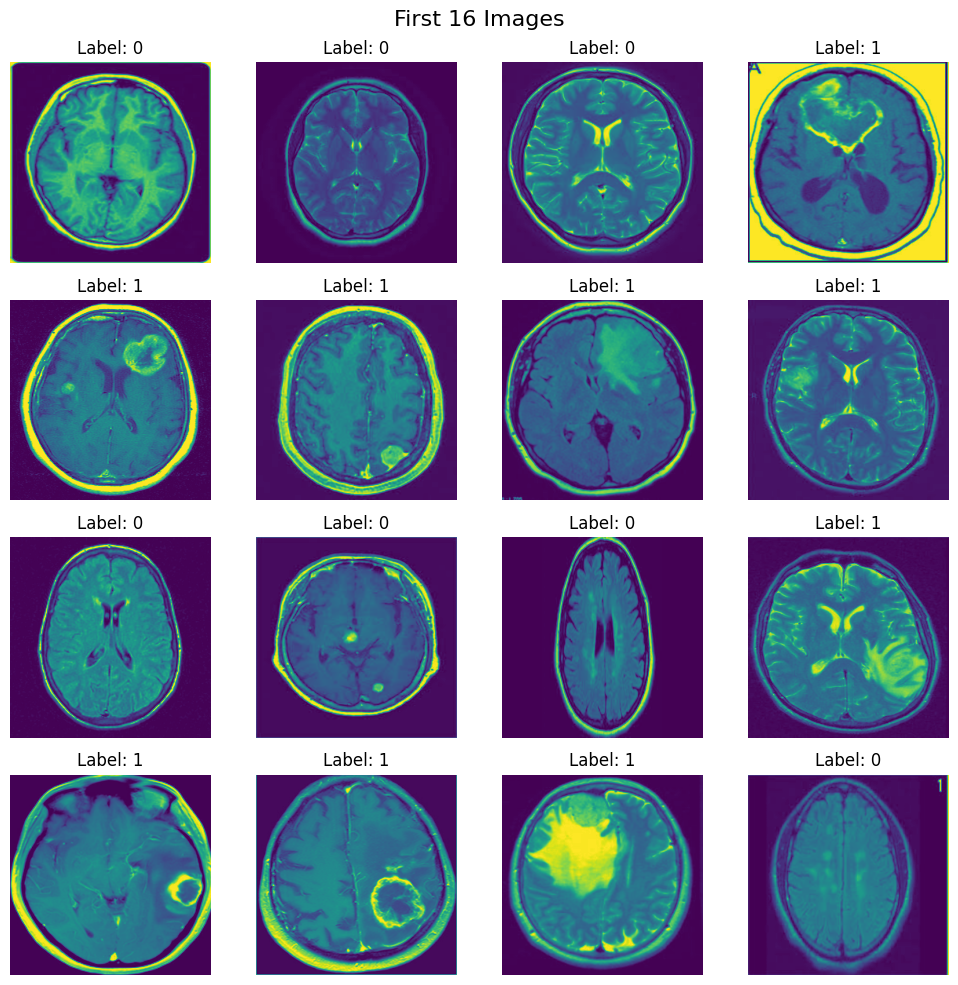

In [9]:
fig, axes = plt.subplots(4, 4, figsize = (10,10))
fig.suptitle("First 16 Images",fontsize = 16)

for i, ax in enumerate(axes.flat):
    img = df.iloc[i,1:].values.reshape(256,256)
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f"Label: {df.iloc[i,0]}")

plt.tight_layout()
plt.show()

In [10]:
# Prepare data for the neural network
# Separate features (pixels) and labels
x = df.iloc[:,1:].values    # All columns except the first one (label)
y = df.iloc[:,0].values     # The first column (label)

In [11]:
# Split the data into training and testing sets
# 80% for training, 20% for testing
x_train,x_test,y_train,y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

In [12]:
# Define custom transformations for the image data for the CNN
# Resize, CenterCrop, and convert to PyTorch Tensor
custom_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
])

In [13]:
# Custom Dataset class for PyTorch
# This class handles loading the pixel data from the numpy arrays,
# reshaping it into an image format, and applying transformations.
class CustomDataset(Dataset):
    def __init__(self,features, labels, transform):

        super().__init__()
        self.features = features
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.features)

    def __getitem__(self, index):

         # Reshape the flattened pixel data back into a square image
        img = self.features[index].reshape(256,256)

         # Convert the single-channel grayscale image to a 3-channel image
        img = np.stack([img]*3, axis = -1)

         # Convert the numpy array image to uint8 type
        img = img.astype(np.uint8)

         # Convert the numpy array image to a PIL Image object
        img = Image.fromarray(img)

        # Apply transformations
        img = self.transform(img)

        return img, torch.tensor(self.labels[index], dtype = torch.long)


In [14]:
# Create instances of the CustomDataset for training and testing data
train_dataset = CustomDataset(x_train, y_train, transform = custom_transform)
test_dataset = CustomDataset(x_test, y_test, transform = custom_transform)

In [15]:
len(train_dataset)

202

In [16]:
# Create DataLoaders for batching and shuffling data during training and testing
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True, pin_memory = True)
test_loader = DataLoader(test_dataset, batch_size = 32, shuffle = False, pin_memory = True)

In [17]:
# Define the Convolutional Neural Network model
class MyNN(nn.Module):
    def __init__(self, input_features):
        super().__init__()

        # Feature extraction layers (Convolutional, ReLU, BatchNorm, MaxPool)
        self.features = nn.Sequential(
             # First convolutional block
            nn.Conv2d(input_features, 32, kernel_size = 3, padding = 'same'),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size = 2, stride = 2),

            # Second convolutional block
            nn.Conv2d(32, 64, kernel_size = 3, padding = 'same'),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size = 2, stride = 2)

        )

        # Classifier layers (Flatten, Linear, ReLU, Dropout)
        self.classifier = nn.Sequential(
            nn.Flatten(),

            nn.Linear(64*56*56,128),
            nn.ReLU(),
            nn.Dropout(p = 0.3),

            nn.Linear(128,64),
            nn.ReLU(),
            nn.Dropout(p = 0.3),

            nn.Linear(64,2)
        )

    def forward(self, x):
     # Pass the input through the feature extraction layers
        x = self.features(x)

        # Pass the output of features through the classifier layers
        x = self.classifier(x) 
        
        return x   

In [18]:
# Instantiate the model
# Input features are 3 because we created a 3-channel image in CustomDataset
model = MyNN(3)
model = model.to(device)

In [19]:
# Define training parameters
epochs = 200
learning_rate = 0.001
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [20]:
# Training loop
for epoch in range(epochs):
    total_epoch_loss = 0

    # Iterate over batches in the training data loader
    for batch_features, batch_labels in train_loader:

        batch_features,batch_labels = batch_features.to(device),batch_labels.to(device)

        output = model(batch_features)
        loss = loss_fn(output,batch_labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_epoch_loss += loss.item()

    avg_loss = total_epoch_loss/len(train_loader) 


In [21]:
model.eval()
total = 0
correct = 0

with torch.no_grad():

    for batch_features,batch_labels in test_loader:
        batch_features,batch_labels = batch_features.to(device),batch_labels.to(device)
        output = model(batch_features)
        _, predicted = torch.max(output, 1)

        total +=batch_labels.shape[0]
        correct += (predicted == batch_labels).sum().item()

print(f"Accuracy: {(correct/total)*100:.4f}%")

Accuracy: 84.3137%
